# WATExR: validation using tercile plots

This notebook performs basic validation of the seasonal forecast output by creating tercile plots. The code is modified from the original [here](https://github.com/icra/WATExR/blob/master/R/validation.R).

In [1]:
# Load packages. 
library(transformeR)
library(visualizeR)
library(Cairo)
library(abind)

transformeR version 1.6.0 (2019-10-04) is loaded
Get the latest stable version (1.6.1) using <devtools::install_github('SantanderMetGroup/transformeR')>
Please see 'citation("transformeR")' to cite this package.
Warning message:
“no DISPLAY variable so Tk is not available”visualizeR version 1.5.0 (2019-10-04) is loaded
Please see 'citation("visualizeR")' to cite this package.


## 1. User settings

In [2]:
# Output path where the generated validation plots will be saved
dir.validation <- '../../Data/Meteorological/04_tercile_plots/'

# Path where the Rdata was saved. Change to your local path)
dir.Rdata <- '../../Data/Meteorological/RData/'

# Observational and seasonal forecasting datasets
obs.dataset <- "PIK_Obs-EWEMBI"
forecast.dataset <- "System4_seasonal_15"

# Select variables for validation
# e.g.
val.variables <- c("uas", "vas", "ps", "tas", "pr", "rsds", "rlds", "hurs", "petH")

# Define metadata to generate the file name
institution <- "NIVA"
lake_id <- "Morsa"
ClimateModelName <- forecast.dataset
ExperimentName <- "seasonal"
freq <- "day"

## 2. Load data

In [3]:
# Define the variables to be loaded
variables <- c("uas", "vas", "ps", "tas", "pr", "rsds", "rlds", "hurs", "petH")
# Or a larger string of variables: c("uas", "vas", "ps", "tas", "hurs", "rsds", "rlds", "cc")  

# Find Rdara according to a name pattern and load with the appropriate path of those printed in the console
list.files(dir.Rdata, pattern = paste0(obs.dataset, "_.*", paste0(variables, collapse = "_")), full.names = TRUE)
obs.data <- get(load("../../Data/Meteorological/RData/PIK_Obs-EWEMBI_1_2_3_4_5_6_7_8_9_10_11_12_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH.rda"))

# Repeat the operation for forecast data
list.files(dir.Rdata, pattern = paste0(forecast.dataset, "_.*", paste0(variables, collapse = "_")), full.names = TRUE)
forecast.data <- get(load("../../Data/Meteorological/RData/System4_seasonal_15_8_9_10_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BC.rda")) 
forecast.data <- lapply(forecast.data, function(x) subsetGrid(x, season = getSeason(x)[-1]))

[1] "../../Data/Meteorological/RData//PIK_Obs-EWEMBI_1_2_3_4_5_6_7_8_9_10_11_12_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH.rda"

[1] "../../Data/Meteorological/RData//System4_seasonal_15_11_12_1_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BC.rda"     
 [2] "../../Data/Meteorological/RData//System4_seasonal_15_11_12_1_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BCcross.rda"
 [3] "../../Data/Meteorological/RData//System4_seasonal_15_11_12_1_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_raw.rda"    
 [4] "../../Data/Meteorological/RData//System4_seasonal_15_2_3_4_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BC.rda"       
 [5] "../../Data/Meteorological/RData//System4_seasonal_15_2_3_4_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BCcross.rda"  
 [6] "../../Data/Meteorological/RData//System4_seasonal_15_2_3_4_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_raw.rda"      
 [7] "../../Data/Meteorological/RData//System4_seasonal_15_5_6_7_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BC.rda"       
 [8] "../../Data/Meteorological/RData//System4_seasonal_15_5_6_7_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BCcross.rda"  
 [9] "../../Data/Meteorological/RData//System4_seasonal_15_5_6_7_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_raw.rda"      
[10] "../../Data/Meteorological/RData//System4_seasonal_15_8_9_10_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BC.rda"      
[11] "../../Data/Meteorological/RData//System4_seasonal_15_8_9_10_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_BCcross.rda" 
[12] "../../Data/Meteorological/RData//System4_seasonal_15_8_9_10_uas_vas_ps_tas_pr_rsds_rlds_hurs_petH_raw.rda"

## 3. Time series plots ???

pad applied on the interval: day
pad applied on the interval: day


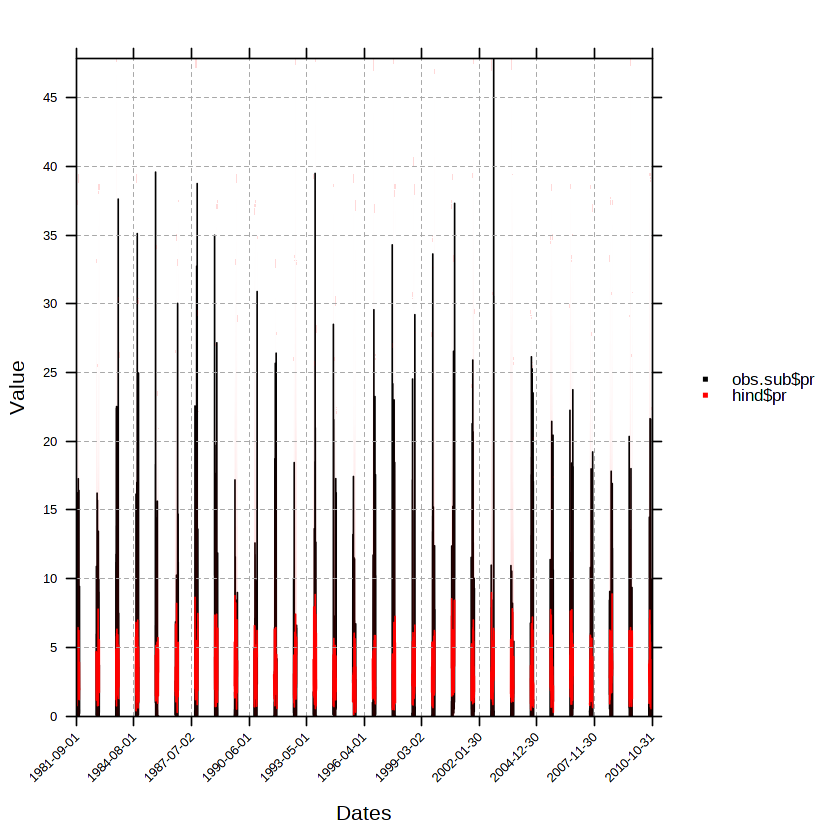

In [4]:
# Retain required variables
ind <- abind(lapply(val.variables, function(x) which(names(obs.data) == x)))
obs <- obs.data[ind]
ind <- abind(lapply(val.variables, function(x) which(names(forecast.data) == x)))
hind <- forecast.data[ind]

if (!identical(names(obs), names(hind))) stop("there is one or more variables missing in the observations and/or forecast data.")

# Subset season in obs # works for spirng-summer-autumn
season <- getSeason(hind[[1]])
obs.sub <- lapply(1:length(obs), function(x) {intersectGrid(obs[[x]], hind[[x]], type = "temporal", which.return = 1)})
hind <- lapply(1:length(obs), function(x) {intersectGrid(obs[[x]], hind[[x]], type = "temporal", which.return = 2)})

names(obs.sub) <- sapply(obs.sub, function(x) getVarNames(x))
names(hind) <- sapply(hind, function(x) getVarNames(x))

temporalPlot(obs.sub$pr, hind$pr)

## 4. Validation

In [5]:
startTime <- format(as.POSIXlt(hind[[1]]$Dates$start[1]), format = "%Y%m%d")
endTime <- format(as.POSIXlt(hind[[1]]$Dates$end[length(hind[[1]]$Dates$end)]), format = "%Y%m%d")

# Create and save tercile plots
for (i in 1:length(val.variables)) {
  filename <- paste0(dir.validation, '/', lake_id, "_", institution, "_", ClimateModelName, "_", ExperimentName, "_", paste0(season, collapse = "_"), "_", freq,"_", startTime, "-", endTime, val.variables[i],"_", ".pdf")
  CairoPDF(file = filename, width = 10)
  tercilePlot(obs = redim(obs.sub[[i]]), hindcast = redim(hind[[i]]))
  dev.off()
}